Notebook for preprocessing and pathways mapping.

**V8** : Version pour K-Fold Cross-Validation
- Pas de train-test split
- Génère des matrices complètes pour chaque type de pathways (full, selected, random)
- Ready for K-Fold CV dans le notebook deep_learning

⚠️ **Note importante** : La feature selection est faite sur le dataset complet ici.
Pour éviter le data leakage, elle devrait être refaite DANS chaque fold du K-Fold CV.

# Setup

## Import

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

import requests
import gseapy as gp

from collections import defaultdict
from sklearn.utils.class_weight import compute_class_weight

from sklearn.manifold import TSNE
#from umap import UMAP
from sklearn.decomposition import PCA


## Setup

In [2]:
preprocessing_folder = Path("nagenes_work/1_Preprocessed_gene_matrices")
pathways_folder = Path("nagenes_work/2_Mapped_pathways_matrices")
final_folder = Path("nagenes_work/3_Prepro_pathways_select_matrices")

for folder in [preprocessing_folder, pathways_folder, final_folder] :
    folder.mkdir(exist_ok=True, parents=True)
    # exist_ok=True : if the folder already exists, don't overwrite it.
    # parents=True : create parent directories if they don't exist

print(f"✅ Dossiers configurés:")
print(f"   - {preprocessing_folder}")
print(f"   - {pathways_folder}")
print(f"   - {final_folder}")

✅ Dossiers configurés:
   - nagenes_work/1_Preprocessed_gene_matrices
   - nagenes_work/2_Mapped_pathways_matrices
   - nagenes_work/3_Prepro_pathways_select_matrices


⚠️ **Important** : Ce notebook doit être exécuté depuis le dossier `/Users/fanny/Desktop/Projet_DL/`

Les fichiers seront sauvegardés dans :
- `nagenes_work/1_Preprocessed_gene_matrices/`
- `nagenes_work/2_Mapped_pathways_matrices/`
- `nagenes_work/3_Prepro_pathways_select_matrices/`

## Load matrix

In [3]:
expression_matrix = pd.read_csv('/Users/fanny/Desktop/Projet_DL/expression_matrix.csv', index_col=0)

labels = ['cancer_label', "survival_label"]
meta_cols = ['years_to_death', 'days_to_death', 'sample_type', 'patient', 'age_at_index', 'vital_status', 'sex', 'stage', 'grade']
label_cols = meta_cols + labels
gene_cols = [col for col in expression_matrix.columns if col not in label_cols]

print(f"   - Genes : {len(gene_cols)}")
print(f"   - Samples : {expression_matrix.shape[0]}")
print(f"   - Shape : {expression_matrix.shape}")

/var/folders/25/gv6drr0j1wd5qjxs262p75lm0000gn/T/ipykernel_37108/114773425.py:1: DtypeWarning: Columns (60664) have mixed types. Specify dtype option on import or set low_memory=False.
  expression_matrix = pd.read_csv('/Users/fanny/Desktop/Projet_DL/expression_matrix.csv', index_col=0)


   - Genes : 60660
   - Samples : 405
   - Shape : (405, 60671)


In [4]:
expression_matrix.columns[-10:]

Index(['cancer_label', 'patient', 'age_at_index', 'days_to_death',
       'vital_status', 'sex', 'stage', 'grade', 'years_to_death',
       'survival_label'],
      dtype='object')

(samples x genes+labels)

sample_type : ['Primary Tumor', 'Solid Tissue Normal', 'Recurrent Tumor'],

label : 0/normal, 1/cancer

patient : patient number (1-353)

In [5]:
expression_matrix['sample_type'].value_counts()

sample_type
Primary Tumor          353
Solid Tissue Normal     49
Recurrent Tumor          3
Name: count, dtype: int64

In [6]:
print("\nLabels distribution :")
print(expression_matrix['cancer_label'].value_counts())
print(f"   - Ratio Tumor/Normal : {expression_matrix['cancer_label'].sum() / (len(expression_matrix) - expression_matrix['cancer_label'].sum()):.2f}")

print("\nPatient distribution :")
print(f"   - Unique patients : {expression_matrix['patient'].nunique()}")
patient_counts = expression_matrix.groupby('patient').size()
duplicates = patient_counts[patient_counts > 1]
print(f"   - Patients with several samples : {len(duplicates)}")


Labels distribution :
cancer_label
1    356
0     49
Name: count, dtype: int64
   - Ratio Tumor/Normal : 7.27

Patient distribution :
   - Unique patients : 353
   - Patients with several samples : 51


# Quality control

## Missing values

In [7]:
# ===== Genes with missing values ===== 

missing_genes = expression_matrix[gene_cols].isna().sum()
genes_with_missing = (missing_genes > 0).sum()

print(f"\nGenes with missing values : {genes_with_missing}")


Genes with missing values : 0


In [8]:
# ===== Samples with missing values ===== 

missing_samples = expression_matrix[gene_cols].isna().sum(axis=1).sum()
samples_with_missing = (missing_samples > 0).sum()

print(f"Samples with missing values : {samples_with_missing}")

Samples with missing values : 0


## Mitonchondrial genes percentage

In [9]:
# ===== Mitochondrial genes percentage per sample ===== 

# Identify mito genes
mito_genes = [gene for gene in gene_cols if gene.startswith("^MT-")]
print(f"Mitochondrial genes found : {len(mito_genes)}")


Mitochondrial genes found : 0


## Total count/expression in samples (sequencing depth) and genes count

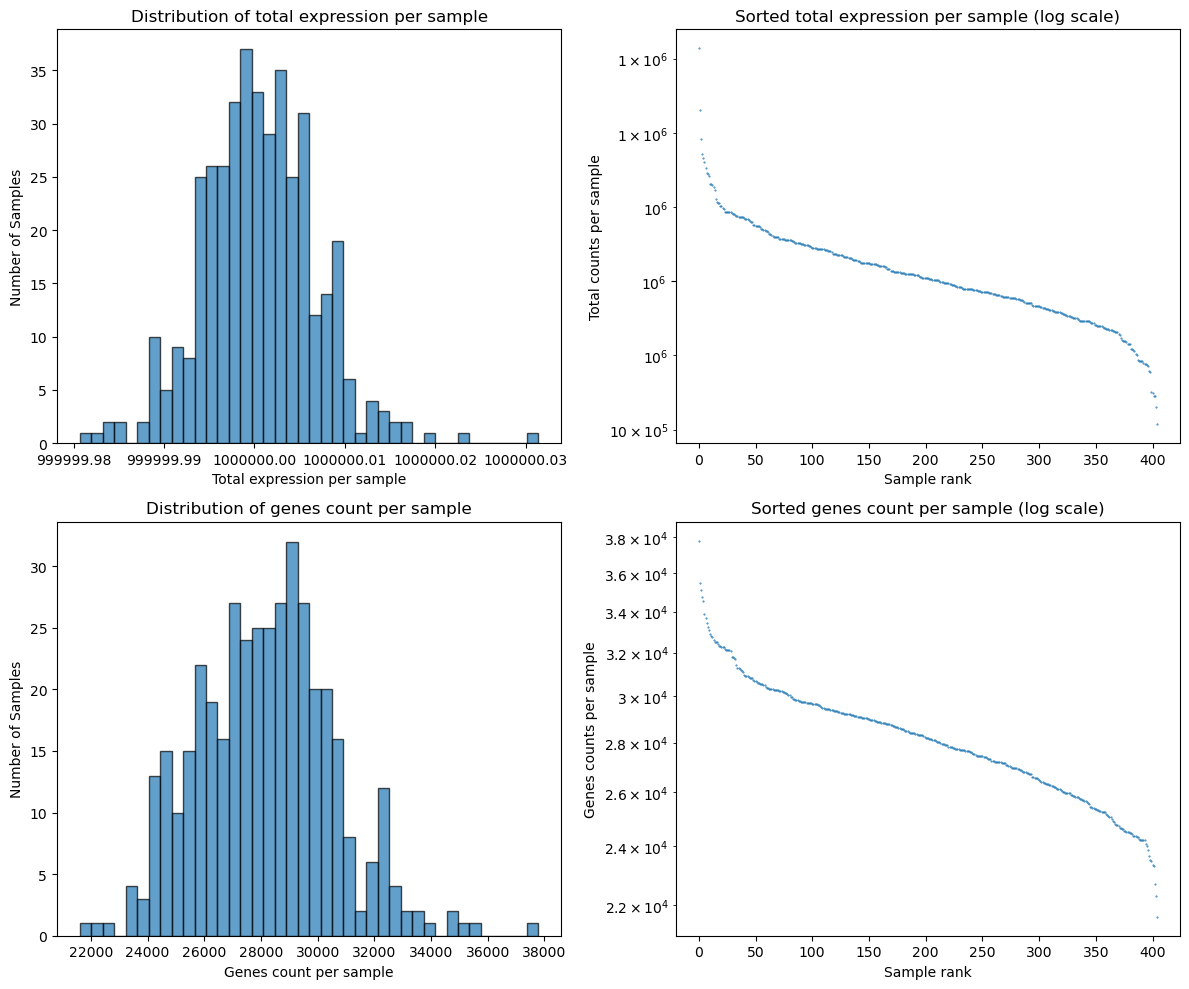

In [10]:
# ===== Total counts per sample ===== 
total_counts = expression_matrix[gene_cols].sum(axis=1)

# ===== Number of genes expressed in samples =====
genes_count = (expression_matrix[gene_cols] > 0).sum(axis=1)

# ===== Plot =====
plt.figure(figsize=(12, 10))

# Histogram of total counts
plt.subplot(2, 2, 1)
plt.hist(total_counts, bins=40, edgecolor='black', alpha=0.7)
plt.xlabel("Total expression per sample")
plt.ylabel("Number of Samples")
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.ticklabel_format(style='plain', axis='x')
plt.title("Distribution of total expression per sample")

# Knee plot of total counts
plt.subplot(2, 2, 2)
x = range(len(total_counts))
y = sorted(total_counts, reverse=True)
plt.scatter(x, y, s=0.2)
plt.xlabel("Sample rank")
plt.ylabel("Total counts per sample")
plt.title("Sorted total expression per sample (log scale)")
plt.yscale("log")

# Histogram of genes count
plt.subplot(2, 2, 3)
plt.hist(genes_count, bins=40, edgecolor='black', alpha=0.7)
plt.xlabel("Genes count per sample")
plt.ylabel("Number of Samples")
plt.title("Distribution of genes count per sample")

# Knee plot of genes count
plt.subplot(2, 2, 4)
x = range(len(genes_count))
y = sorted(genes_count, reverse=True)
plt.scatter(x, y, s=0.2)
plt.xlabel("Sample rank")
plt.ylabel("Genes counts per sample")
plt.title("Sorted genes count per sample (log scale)")
plt.yscale("log")

plt.tight_layout()
plt.show()

No visible low-sequencing samples or outliers.

# Preprocessing (sans split pour K-Fold)

## Removal of non expressed and lowly expressed genes

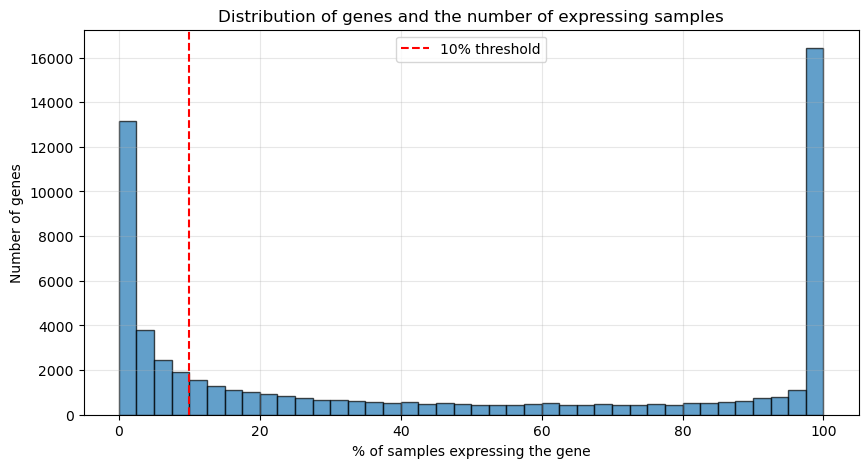

In [11]:
# ===== Non expressed and lowly expressed genes ===== 

# For each gene, count how many samples express it (expression > 0)
samples_expressing_genes = (expression_matrix[gene_cols] > 0).sum(axis=0)

# Calculate for each gene, in how many samples it's expressed, in %
total_samples = len(expression_matrix)
percent_expressing = (samples_expressing_genes / total_samples) * 100

plt.figure(figsize=(10, 5))
plt.hist(percent_expressing, bins=40, edgecolor='black', alpha=0.7)
plt.xlabel('% of samples expressing the gene')
plt.ylabel('Number of genes')
plt.title('Distribution of genes and the number of expressing samples')
plt.axvline(10, color='red', linestyle='--', label='10% threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [12]:
# Only keep genes expressed in more than 10% of samples

# Series of genes expressed in more than 10% of samples
genes_high = percent_expressing[percent_expressing > 10].index.tolist()     # New genes list

print("===== Filtering : removal of lowly expressed genes =====")
print(f"Before : {len(gene_cols)} genes")

expression_matrix_filt = expression_matrix[genes_high + label_cols]     # New filtered matrix
genes_out = len(gene_cols) - len(genes_high)
genes_out_pc = genes_out / len(gene_cols) *100

print(f"After : {len(genes_high)} gènes")
print(f"Filtered out : {genes_out} genes   = {genes_out_pc:.2f} %")


===== Filtering : removal of lowly expressed genes =====
Before : 60660 genes
After : 39347 gènes
Filtered out : 21313 genes   = 35.14 %


## Préparation pour K-Fold CV

✅ **Pas de train-test split** : On garde toutes les données pour le K-Fold CV.

Le K-Fold CV fera automatiquement les splits train/validation/test dans chaque fold.

In [13]:
# ===== Préparation pour K-Fold CV (pas de train-test split) =====

meta_cols = [col for col in label_cols if col not in ['cancer_label']]
X = expression_matrix_filt[genes_high + meta_cols]
y = expression_matrix_filt['cancer_label']

print("===== Dataset complet pour K-Fold CV =====")
print(f"Total samples: {X.shape[0]}")
print(f"Features: {len(genes_high)} genes")
print(f"\nClass distribution:")
print(y.value_counts())
for label, count in y.value_counts().items():
    print(f"  Classe {label}: {count} ({count/len(y)*100:.1f}%)")

===== Dataset complet pour K-Fold CV =====
Total samples: 405
Features: 39347 genes

Class distribution:
cancer_label
1    356
0     49
Name: count, dtype: int64
  Classe 1: 356 (87.9%)
  Classe 0: 49 (12.1%)


## Log transformation

In [14]:
# ===== Log transformation =====

print("===== Log transformation =====")
print(f"\nBefore transformation :")
print(f"   - Min : {X[genes_high].min().min():.2f}")
print(f"   - Max : {X[genes_high].max().max():.2f}")
print(f"   - Median : {X[genes_high].median().median():.2f}")

X_transformed = X.copy()
X_transformed[genes_high] = np.log2(X[genes_high] + 1)

print(f"\nAfter log2(x+1) :")
print(f"   - Min : {X_transformed[genes_high].min().min():.2f}")
print(f"   - Max : {X_transformed[genes_high].max().max():.2f}")
print(f"   - Median : {X_transformed[genes_high].median().median():.2f}")

===== Log transformation =====

Before transformation :
   - Min : 0.00
   - Max : 173270.06
   - Median : 0.15

After log2(x+1) :
   - Min : 0.00
   - Max : 17.40
   - Median : 0.21


In [17]:
# Save complete matrix
X_transformed.to_csv(preprocessing_folder / "complete_genes_matrix_preprocessed_cancer.csv")
print(f"✅ Matrice sauvegardée: complete_genes_matrix_preprocessed_cancer.csv")
print(f"   Shape: {X_transformed.shape}")

✅ Matrice sauvegardée: complete_genes_matrix_preprocessed_cancer.csv
   Shape: (405, 39357)


# Pathways mapping

## Mapping of genes to pathways

3 matrices : with full library pathways, with pathways selected with cancer keywords, with randomly selected pathways.

In [18]:
# Download MSigDB pathways (Hallmark = 50 well-defined pathways)
gene_sets = gp.get_library_name()  # Look at available collections
print("Available selected_selected_selected_selected_selected_msigdb Collections :", gene_sets[:10])

Available selected_selected_selected_selected_selected_msigdb Collections : ['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021']


In [ ]:
# TODO: try GO instead of MSigDB.
# Use Hallmark (H) or Canonical Pathways (C2)
#msigdb_full = gp.parser.download_library('GO_Biological_Process_2023', 'Human')     # dict
# Or for more pathways : 'c2.cp.v2023.1.Hs.symbols'
msigdb = gp.parser.download_library('MSigDB_Hallmark_2020', 'Human')
#msigdb = gp.parser.download_library('MSigDB_Hallmark_2020', 'Human')
#msigdb = gp.parser.download_library('Oncogenic_Signature_2', 'Human')

# ===== Filter pathways relevant to cancer =====

cancer_keywords = [
    # General cancer terms
    'cancer', 'tumor', 'tumour', 'neoplasm', 'carcinoma', 'oncogen', 'malignant', 'sarcoma', 'lymphoma',
    
    # Key cellular processes
    'apoptosis', 'proliferation', 'cell cycle', 'cell division', 'cell growth', 'senescence',
    
    # Metastasis and invasion
    'metastasis', 'invasion', 'migration', 'adhesion', 'emt', 'epithelial mesenchymal transition', #  'extravasation',
    
    # DNA damage and repair
    'dna damage', 'dna repair', 'mutation', 'telomere',
    
    # Cellular stress
    'stress response', 'oxidative stress', 'hypoxia', 
    
    # Cancer metabolism
    'glycolysis', 'glucose', 'warburg effect', 'lactate', 'metabolism', 
    
    # Immune and microenvironment
    'immune escape', 'checkpoint', 'tumor microenvironment', 'tme',
    
    # Angiogenesis and vasculature
    'angiogenesis', 'endothelial', 'neovascularization',
    
    # Stemness and differentiation
    'stem cell', 'cancer stem', #'pluripotent', 'differentiation', 
    
    # Inflammation
    'inflammation', 'inflammatory', 'tnf', 'nf-kappa', 'cytokine', 'chemokine', 'il-6',
]

msigdb_selected = {}
for pathway_name, genes in msigdb_full.items():
    pathway_lower = pathway_name.lower()
    if any(keyword in pathway_lower for keyword in cancer_keywords):
        msigdb_selected[pathway_name] = genes
        # In msigdb dicts, a pathway key has gene values

print(f"\n{len(msigdb_selected)} filtered cancer-related pathways (out of {len(msigdb_full)} total)")
print(f"Example: {list(msigdb_selected.keys())[:3]}")


# ===== Map selected genes to pathways =====

# Make lists of genes, for the full library and for selected cancer keywords 
msigdb_full_genes = []
for genes in msigdb_full.values() :
    for g in genes :
        msigdb_full_genes.append(g)

select_msigdb_genes = []
for genes in msigdb_selected.values() :
    for g in genes :
        select_msigdb_genes.append(g)

# Make lists of genes in common between the dataset and the library
full_mapped_genes = [g for g in genes_high if g in msigdb_full_genes]
select_mapped_genes = [g for g in genes_high if g in select_msigdb_genes]
print(f"\nMapped genes in full library : {len(full_mapped_genes)}/{len(genes_high)}")
print(f"Mapped genes in selected pathways : {len(select_mapped_genes)}/{len(genes_high)}")


541 filtered cancer-related pathways (out of 5407 total)
Example: ['B Cell Proliferation (GO:0042100)', 'DNA Damage Checkpoint Signaling (GO:0000077)', 'DNA Damage Response (GO:0006974)']

Mapped genes in full library : 13979/39347
Mapped genes in selected pathways : 4495/39347


In [20]:
# Make dataframes with the genes in common between the dataset and the library
pathways_dt = {}

# ===== SELECT RANDOM PATHWAYS ONCE =====
# Set seed for reproducibility
np.random.seed(42)
random_pathway_names = np.random.choice(list(msigdb_full.keys()), size=len(msigdb_selected), replace=False)
msigdb_random = {pathway: msigdb_full[pathway] for pathway in random_pathway_names}
print(f"\n  Random pathways selected: {len(msigdb_random)}")
print(f"   Examples: {list(random_pathway_names[:3])}\n")

print(f"\n===== Mapping pathways sur dataset complet =====")

full_pathways_matrix = pd.DataFrame(0, 
                            index=X_transformed.index, 
                            columns=list(msigdb_full.keys()))

select_pathways_matrix = pd.DataFrame(0, 
                            index=X_transformed.index, 
                            columns=list(msigdb_selected.keys()))

# Aggregate expression by pathway (mean)
# Matrix with all pathways
for pathway, genes in msigdb_full.items():
    genes_in_data = [g for g in genes if g in full_mapped_genes]
    if genes_in_data:
        full_pathways_matrix[pathway] = X_transformed[genes_in_data].mean(axis=1)
        
# Matrix with cancer keyword pathways
for pathway, genes in msigdb_selected.items():
    genes_in_data = [g for g in genes if g in select_mapped_genes]
    if genes_in_data:
        select_pathways_matrix[pathway] = X_transformed[genes_in_data].mean(axis=1)

# Matrix with random pathways
random_pathways_matrix = full_pathways_matrix[random_pathway_names]

print(f"Final full matrix:     {full_pathways_matrix.shape[0]} samples × {full_pathways_matrix.shape[1]} pathways")
print(f"Final selected matrix: {select_pathways_matrix.shape[0]} samples × {select_pathways_matrix.shape[1]} pathways")
print(f"Final random matrix:   {random_pathways_matrix.shape[0]} samples × {random_pathways_matrix.shape[1]} pathways")

# ----- Add metadata and labels before saving -----
full_pathways_matrix = pd.concat([full_pathways_matrix, X_transformed[meta_cols], y], axis=1)
select_pathways_matrix = pd.concat([select_pathways_matrix, X_transformed[meta_cols], y], axis=1)
random_pathways_matrix = pd.concat([random_pathways_matrix, X_transformed[meta_cols], y], axis=1)

# Save in dict
pathways_dt["full"] = full_pathways_matrix
pathways_dt["selected"] = select_pathways_matrix
pathways_dt["random"] = random_pathways_matrix

# Save in csv
full_pathways_matrix.to_csv(pathways_folder / 'complete_full_pathways_matrix_cancer.csv')
with open(pathways_folder / 'complete_full_pathway_to_genes_cancer.pkl', 'wb') as f:
    pickle.dump(msigdb_full, f)

select_pathways_matrix.to_csv(pathways_folder / 'complete_selected_pathways_matrix_cancer.csv')
with open(pathways_folder / 'complete_selected_pathway_to_genes_cancer.pkl', 'wb') as f:
    pickle.dump(msigdb_selected, f)

random_pathways_matrix.to_csv(pathways_folder / 'complete_random_pathways_matrix_cancer.csv')
with open(pathways_folder / 'complete_random_pathway_to_genes_cancer.pkl', 'wb') as f:
    pickle.dump(msigdb_random, f)

print("\n✅ Matrices de pathways sauvegardées")

# NOTE :
# Matrices now contain features, meta_cols and cancer_label


  Random pathways selected: 541
   Examples: ['Regulation Of Gluconeogenesis (GO:0006111)', 'Medium-Chain fatty-acyl-CoA Metabolic Process (GO:0036112)', 'Negative Regulation Of Alpha-Beta T Cell Differentiation (GO:0046639)']


===== Mapping pathways sur dataset complet =====
Final full matrix:     405 samples × 5407 pathways
Final selected matrix: 405 samples × 541 pathways
Final random matrix:   405 samples × 541 pathways

✅ Matrices de pathways sauvegardées


In [21]:
# Check matrices

print("\n========== Vérification des matrices ==========")

for type_name, pathways_matrix in pathways_dt.items():
    print(f"\n----- {type_name} pathways -----")
    print(f"Shape: {pathways_matrix.shape}")
    print("\nFirst columns:")   # Should be pathways
    print(pathways_matrix.columns[:5].tolist())
    print("\nLast columns:")     # Last ones should be metadata and cancer_label
    print(pathways_matrix.columns[-5:].tolist())
    print("\n")

# NOTE :
# pathways_dt keys : full, selected, random
# Each matrix contains: pathways + meta_cols + cancer_label


========== Vérification des matrices ==========

----- full pathways -----
Shape: (405, 5418)

First columns:
["'De Novo' AMP Biosynthetic Process (GO:0044208)", "'De Novo' Post-Translational Protein Folding (GO:0051084)", '2-Oxoglutarate Metabolic Process (GO:0006103)', "3'-UTR-mediated mRNA Destabilization (GO:0061158)", "3'-UTR-mediated mRNA Stabilization (GO:0070935)"]

Last columns:
['sex', 'stage', 'grade', 'survival_label', 'cancer_label']



----- selected pathways -----
Shape: (405, 552)

First columns:
['B Cell Proliferation (GO:0042100)', 'DNA Damage Checkpoint Signaling (GO:0000077)', 'DNA Damage Response (GO:0006974)', 'DNA Damage Response, Signal Transduction By P53 Class Mediator (GO:0030330)', 'DNA Damage Response, Signal Transduction By P53 Class Mediator Resulting In Cell Cycle Arrest (GO:0006977)']

Last columns:
['sex', 'stage', 'grade', 'survival_label', 'cancer_label']



----- random pathways -----
Shape: (405, 552)

First columns:
['Regulation Of Gluconeogenesi

## Quality control

On the complete dataset (pas de split)

### Missing values

In [22]:
# ===== Pathways with missing values ===== 

full_pathways_complete = pathways_dt["full"]
pathway_cols = [col for col in full_pathways_complete.columns if col not in label_cols]

missing_pathways = full_pathways_complete[pathway_cols].isna().sum()
pathways_with_missing = (missing_pathways > 0).sum()
print(f"Pathways with missing values : {pathways_with_missing}")

Pathways with missing values : 0


In [23]:
# ===== Samples with missing values ===== 

missing_samples = full_pathways_complete[pathway_cols].isna().sum(axis=1).sum()
samples_with_missing = (missing_samples > 0).sum()

print(f"Samples with missing values : {samples_with_missing}")

Samples with missing values : 0


### Pathway expression visualizations

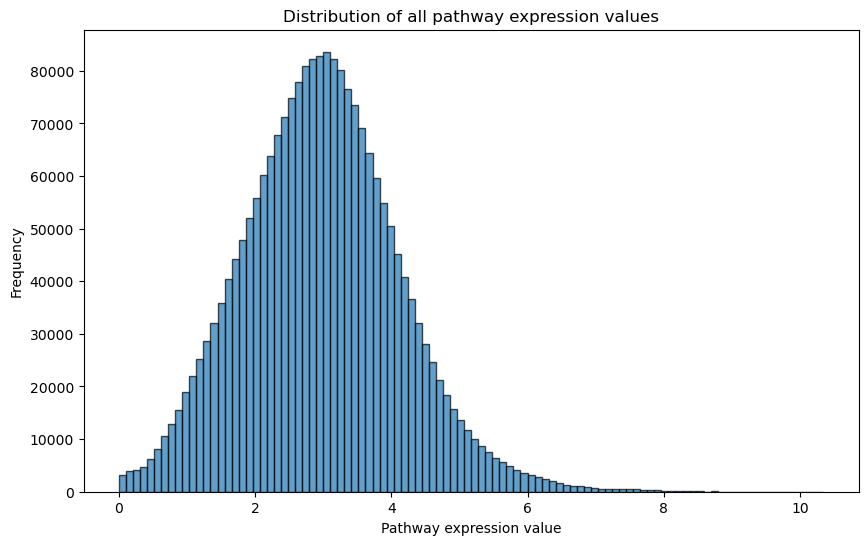

In [24]:
# Distribution of pathway expression
plt.figure(figsize=(10, 6))
plt.hist(full_pathways_complete[pathway_cols].values.flatten(), bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Pathway expression value')
plt.ylabel('Frequency')
plt.title('Distribution of all pathway expression values')
plt.show()



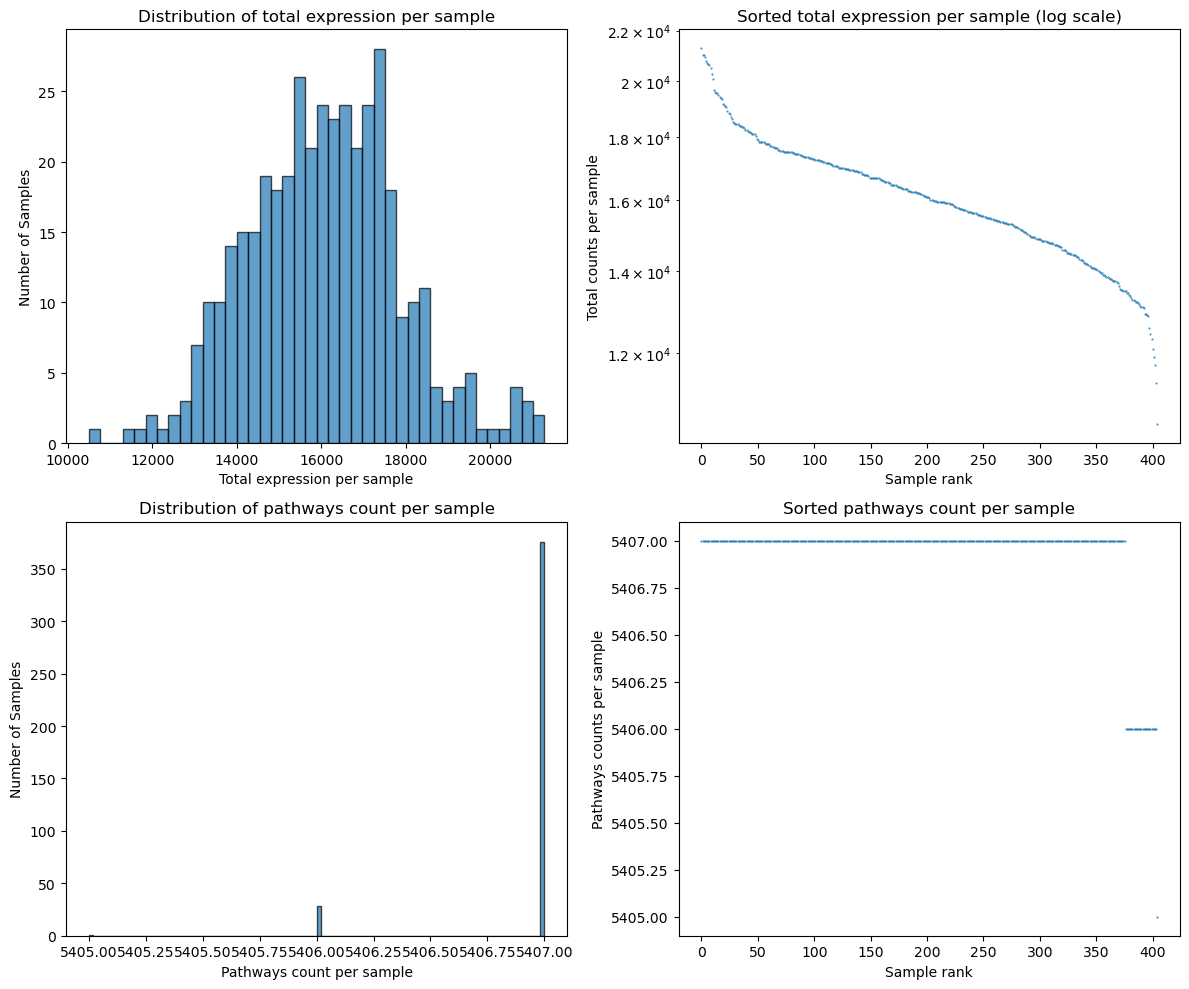

In [25]:
# ===== Total counts per sample ===== 
total_counts = full_pathways_complete[pathway_cols].sum(axis=1)

# ===== Number of pathways expressed in samples =====
pathways_count = (full_pathways_complete[pathway_cols] > 0).sum(axis=1)

# ===== Plot =====
plt.figure(figsize=(12, 10))

# Histogram of total counts
plt.subplot(2, 2, 1)
plt.hist(total_counts, bins=40, edgecolor='black', alpha=0.7)
plt.xlabel("Total expression per sample")
plt.ylabel("Number of Samples")
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.ticklabel_format(style='plain', axis='x')
plt.title("Distribution of total expression per sample")

# Knee plot of total counts
plt.subplot(2, 2, 2)
x = range(len(total_counts))
y = sorted(total_counts, reverse=True)
plt.scatter(x, y, s=0.2)
plt.xlabel("Sample rank")
plt.ylabel("Total counts per sample")
plt.title("Sorted total expression per sample (log scale)")
plt.yscale("log")

# Histogram of pathways count
plt.subplot(2, 2, 3)
plt.hist(pathways_count, bins=100, edgecolor='black', alpha=0.7)
plt.xlabel("Pathways count per sample")
plt.ylabel("Number of Samples")
plt.title("Distribution of pathways count per sample")

# Knee plot of pathways count
plt.subplot(2, 2, 4)
x = range(len(pathways_count))
y = sorted(pathways_count, reverse=True)
plt.scatter(x, y, s=0.2)
plt.xlabel("Sample rank")
plt.ylabel("Pathways counts per sample")
plt.title("Sorted pathways count per sample")
# plt.yscale("log") 

plt.tight_layout()
plt.show()

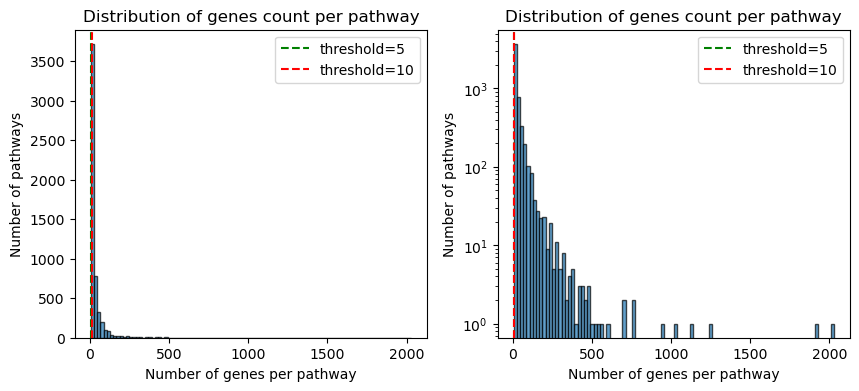

Mean genes per pathway: 32.7
Median genes per pathway: 15.0 

Pathways with < 5 genes: 0 (0.00%)
Pathways with < 10 genes: 1770 (32.74%)
Pathways with < 20 genes: 3286 (60.77%)


In [26]:
# ===== Filter pathways with a low gene count  =====

genes_per_pathway = {pathway: len(genes) for pathway, genes in msigdb_full.items()}
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(list(genes_per_pathway.values()), bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Number of genes per pathway')
plt.ylabel('Number of pathways')
plt.title('Distribution of genes count per pathway')
plt.axvline(5, label="threshold=5", color="green", linestyle="--")
plt.axvline(10, label="threshold=10", color="red", linestyle="--")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(list(genes_per_pathway.values()), bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Number of genes per pathway')
plt.ylabel('Number of pathways')
plt.title('Distribution of genes count per pathway')
plt.axvline(5, label="threshold=5", color="green", linestyle="--")
plt.axvline(10, label="threshold=10", color="red", linestyle="--")
plt.yscale("log")
plt.legend()
plt.show()

print(f"Mean genes per pathway: {np.mean(list(genes_per_pathway.values())):.1f}")
print(f"Median genes per pathway: {np.median(list(genes_per_pathway.values())):.1f} \n")

# Print statistics for pathways under different thresholds
for n in [5, 10, 20] :
    pathways_under_threshold = sum(1 for count in genes_per_pathway.values() if count < n)
    percentage = (pathways_under_threshold / len(genes_per_pathway)) * 100
    print(f"Pathways with < {n} genes: {pathways_under_threshold} ({percentage:.2f}%)")



### Filtering : pathways with few genes

In [27]:
# TODO: Add a visualization before and after filtering?

# Choose threshold and filter pathways
threshold = 10
print(f"\n===== Filtering pathways with < {threshold} genes =====")

# Filter msigdb_full
msigdb_full_filtered = {pathway: genes for pathway, genes in msigdb_full.items() 
                        if len(genes) >= threshold}


print(f"Before filtering: {len(msigdb_full)} pathways")
print(f"After filtering: {len(msigdb_full_filtered)} pathways")
print(f"Removed: {len(msigdb_full) - len(msigdb_full_filtered)}   = {((len(msigdb_full) - len(msigdb_full_filtered)) / len(msigdb_full) * 100):.2f}% pathways")

# Filter pathway_cols to match msigdb_full_filtered
pathway_cols_filtered = [col for col in pathway_cols if col in msigdb_full_filtered.keys()]

print(f"\nPathway columns before filtering: {len(pathway_cols)}")
print(f"Pathway columns after filtering: {len(pathway_cols_filtered)}")
print(f"Removed columns: {len(pathway_cols) - len(pathway_cols_filtered)}")



===== Filtering pathways with < 10 genes =====
Before filtering: 5407 pathways
After filtering: 3637 pathways
Removed: 1770   = 32.74% pathways

Pathway columns before filtering: 5407
Pathway columns after filtering: 3637
Removed columns: 1770


# Feature selection

---

## ⚠️ IMPORTANT : Organisation pour K-Fold sans Data Leakage

**Les sections suivantes (Feature Selection avec p-value) sont CONSERVÉES pour documentation uniquement.**

Pour un K-Fold CV correct **SANS data leakage**, vous devez :

### ✅ CE QUE FAIT CE NOTEBOOK :
- Génère les matrices COMPLÈTES dans `2_Mapped_pathways_matrices/`
- Ces matrices contiennent TOUS les pathways (avant feature selection)
- Fichiers : `complete_*_pathways_matrix_cancer.csv`

### ✅ CE QUE FAIT deep_learning_kfold.ipynb :
- Charge les matrices depuis `2_Mapped_pathways_matrices/`
- **Fait la feature selection DANS chaque fold**
- Chaque fold sélectionne ses propres features (sur train uniquement)

### 📂 Organisation des dossiers :
```
nagenes_work/
├── 2_Mapped_pathways_matrices/        ← UTILISÉ pour K-Fold
│   └── complete_*_pathways_matrix_cancer.csv  (TOUS les pathways)
│
└── 3_Prepro_pathways_select_matrices/ ← Legacy (ne pas utiliser)
    └── complete_*pathways_matrix_cancer.csv   (avec feature selection = leakage)
```

**📊 Résultat attendu** :
- Scores ~92-95% (réalistes)
- Au lieu de ~96-98% (avec leakage)

---

## Projection before feature selection

In [28]:
# ===== Projection before feature selection ===== 

# NOTE :
# Matrices now contain features, meta_cols and cancer_label

feature_cols = [col for col in full_pathways_complete.columns if col not in label_cols]

# Prepare data for dimensionality reduction
X_proj = full_pathways_complete[feature_cols].values
labels = full_pathways_complete['cancer_label'].values

# UMAP
umap = UMAP(n_components=2, random_state=42)
umap_embedding = umap.fit_transform(X_proj)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_embedding = tsne.fit_transform(X_proj)

# PCA 
pca = PCA()
X_train_pca = pca.fit_transform(X_proj)

# ----- Plot -----
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# UMAP plot
for label_val in [0, 1]:
    mask = labels == label_val
    axes[0,0].scatter(umap_embedding[mask, 0], umap_embedding[mask, 1], 
                     label=f'Label {label_val}', s=40, alpha=0.7)
axes[0,0].set_title('UMAP')
axes[0,0].set_xlabel('UMAP 1')
axes[0,0].set_ylabel('UMAP 2')
axes[0,0].legend()

# t-SNE plot
for label_val in [0, 1]:
    mask = labels == label_val
    axes[0,1].scatter(tsne_embedding[mask, 0], tsne_embedding[mask, 1], 
                     label=f'Label {label_val}', s=40, alpha=0.7)
axes[0,1].set_title('t-SNE')
axes[0,1].set_xlabel('t-SNE 1')
axes[0,1].set_ylabel('t-SNE 2')
axes[0,1].legend()

# PCA plot
for label_val in [0, 1]:
    mask = labels == label_val
    axes[1,0].scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], 
                     label=f'Label {label_val}', s=40, alpha=0.6, 
                     linewidth=0.5)
axes[1,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)')
axes[1,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)')
axes[1,0].set_title('2D PCA Projection (PC1 vs PC2)')
axes[1,0].legend()

# Hide the empty subplot
axes[1,1].axis('off')

plt.suptitle("Data projection before feature selection on pathways")
plt.tight_layout()
plt.show()

NameError: name 'UMAP' is not defined

## SelectKBest avec p-value

⚠️ **DATA LEAKAGE WARNING** : On fait la feature selection sur TOUTES les données.

Pour éviter le data leakage dans K-Fold CV, la feature selection devrait être faite **DANS chaque fold**.

### 🚨 DATA LEAKAGE : Explication détaillée

#### **Problème actuel :**

Dans ce notebook, on fait la feature selection sur **TOUTES les données** avant le K-Fold CV :
```python
# ❌ MAUVAIS : Feature selection sur dataset complet
X_all = pathways_matrix[feature_cols]
y_all = pathways_matrix['cancer_label']
selector = SelectKBest(f_classif, k=50)
selector.fit(X_all, y_all)  # ← Utilise les données de test !
```

**Conséquence** : Le modèle "voit" indirectement les données de test via la sélection des features, ce qui gonfle artificiellement les performances.

---

#### **Pourquoi c'est un problème ?**

1. **Information leakage** : La feature selection utilise les labels (y) pour calculer les p-values
2. **Test set contaminé** : Les features sont choisies en fonction de TOUTES les données, y compris le test fold
3. **Optimisme des scores** : Les métriques sont gonflées de ~2-5% typiquement
4. **Pas de vraie généralisation** : Le modèle ne peut pas prédire correctement sur de nouvelles données

**Exemple concret :**
- Vous avez 374 échantillons et 5000 pathways
- La feature selection choisit les 50 pathways les plus discriminants
- Elle utilise les 374 échantillons (train + test) pour faire ce choix
- Quand vous testez sur le fold test, il connaît déjà les "bonnes" features

---

#### **Solution : Feature selection DANS chaque fold**

```python
# ✅ BON : Feature selection dans chaque fold
for fold in k_folds:
    # 1. Séparer train/test
    train_indices, test_indices = fold.split(X, y)
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    # 2. Feature selection UNIQUEMENT sur train
    selector = SelectKBest(f_classif, k=50)
    selector.fit(X_train, y_train)  # ← Seulement train !
    
    # 3. Appliquer la même transformation à train ET test
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)
    
    # 4. Entraîner et évaluer
    model.fit(X_train_selected, y_train)
    score = model.score(X_test_selected, y_test)
```

---

#### **Workflow correct pour K-Fold CV :**

Pour **chaque fold** :

1. **Split** : Séparer train (80%) et test (20%)
2. **Fit selector** : `selector.fit(X_train, y_train)` ← Seulement train !
3. **Transform** : Appliquer à train et test
   - `X_train_selected = selector.transform(X_train)`
   - `X_test_selected = selector.transform(X_test)`
4. **Train model** : Sur `X_train_selected`
5. **Evaluate** : Sur `X_test_selected`

**Important** : Les features sélectionnées peuvent être **différentes** d'un fold à l'autre !

---

#### **Différence de scores attendue :**

Avec data leakage (actuel) :
- Accuracy : ~96-98% 😱 (trop optimiste)

Sans data leakage (correct) :
- Accuracy : ~92-95% ✅ (réaliste)

**Si vos scores restent >95% après correction**, c'est un excellent résultat ! Mais ils seront plus fiables.

---

#### **Implémentation dans deep_learning_kfold.ipynb :**

Le notebook devrait :
1. Charger la matrice **AVANT** feature selection (dans `2_Mapped_pathways_matrices/`)
2. Faire la feature selection dans `run_kfold_cv()`
3. Pour chaque fold, sélectionner les features indépendamment

Voir la section suivante pour l'implémentation.

### 💡 Exemple d'implémentation correcte

Voici comment implémenter la feature selection sans data leakage dans votre pipeline K-Fold :

```python
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold

def run_kfold_with_feature_selection(X, y, n_splits=4, k_features=50):
    """
    K-Fold CV avec feature selection dans chaque fold
    
    Parameters:
    -----------
    X : array (n_samples, n_features)
        Matrice complète AVANT feature selection
    y : array (n_samples,)
        Labels
    k_features : int
        Nombre de features à sélectionner
    """
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []
    
    for fold, (train_val_idx, test_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n===== FOLD {fold} =====")
        
        # 1. Séparer train+val et test
        X_train_val = X[train_val_idx]
        X_test = X[test_idx]
        y_train_val = y[train_val_idx]
        y_test = y[test_idx]
        
        # 2. Re-split train_val en train et val (80/20)
        train_size = int(0.8 * len(train_val_idx))
        train_idx = np.arange(train_size)
        val_idx = np.arange(train_size, len(train_val_idx))
        
        X_train = X_train_val[train_idx]
        X_val = X_train_val[val_idx]
        y_train = y_train_val[train_idx]
        y_val = y_train_val[val_idx]
        
        # 3. ✅ Feature selection UNIQUEMENT sur train
        print(f"  Feature selection sur {len(X_train)} échantillons train...")
        selector = SelectKBest(f_classif, k=k_features)
        selector.fit(X_train, y_train)
        
        # Obtenir les features sélectionnées
        selected_features = selector.get_support()
        selected_feature_names = feature_names[selected_features]
        print(f"  Features sélectionnées: {len(selected_feature_names)}")
        
        # 4. Transformer train, val, test avec le MÊME selector
        X_train_selected = selector.transform(X_train)
        X_val_selected = selector.transform(X_val)
        X_test_selected = selector.transform(X_test)
        
        print(f"  Train shape: {X_train_selected.shape}")
        print(f"  Val shape:   {X_val_selected.shape}")
        print(f"  Test shape:  {X_test_selected.shape}")
        
        # 5. Entraîner l'autoencoder sur données sélectionnées
        autoencoder = train_autoencoder(X_train_selected, X_val_selected)
        
        # 6. Encoder les données
        X_train_encoded = autoencoder.encode(X_train_selected)
        X_val_encoded = autoencoder.encode(X_val_selected)
        X_test_encoded = autoencoder.encode(X_test_selected)
        
        # 7. Entraîner le MLP
        mlp = train_mlp(X_train_encoded, y_train, X_val_encoded, y_val)
        
        # 8. Évaluer sur test
        test_accuracy = evaluate(mlp, X_test_encoded, y_test)
        
        fold_results.append({
            'fold': fold,
            'selected_features': selected_feature_names,
            'test_accuracy': test_accuracy,
            'selector': selector,
            'autoencoder': autoencoder,
            'mlp': mlp
        })
    
    return fold_results
```

---

### 📊 Comparaison des approches

| Aspect | ❌ Avec data leakage | ✅ Sans data leakage |
|--------|---------------------|---------------------|
| **Feature selection** | Sur toutes les données | Dans chaque fold |
| **Features sélectionnées** | Toujours les mêmes | Peuvent varier par fold |
| **Accuracy moyenne** | ~96-98% (gonflée) | ~92-95% (réaliste) |
| **Généralisation** | Surestimée | Vraie performance |
| **Publication** | Non acceptable | Acceptable |

---

### 🎯 Pour corriger le notebook deep_learning_kfold.ipynb

**Option 1** : Utiliser les matrices **AVANT** feature selection
```python
# Au lieu de :
data_folder / "complete_selectedpathways_matrix_cancer.csv"  # ❌ Déjà filtré

# Utiliser :
data_folder / "complete_selected_pathways_matrix_cancer.csv"  # ✅ Sans feature selection
# Depuis le dossier "2_Mapped_pathways_matrices/" au lieu de "3_Prepro_pathways_select_matrices/"
```

**Option 2** : Modifier `run_kfold_cv()` pour intégrer la feature selection

Je peux vous créer la version corrigée si vous voulez !

SelectKBest selects the top K features (variables) based on their scores from a statistical test.

___
ANOVA (Analysis of Variance) F-test (f_classif) is a statistical test that compares the means of multiple groups to determine if at least one group mean is significantly different from the others.

F-statistic = Between-group variance / Within-group variance

High F-value: Gene expression differs significantly between groups

Low F-value: No significant difference between groups

p-value: Probability that observed differences occurred by chance

In [ ]:
from sklearn.feature_selection import f_classif

p_value_threshold = 0.005
selected_pathways_dt = {}

print("\n" + "="*70)
print("⚠️ Feature Selection sur dataset COMPLET (pour K-Fold CV)")
print("NOTE: La feature selection devrait être faite DANS chaque fold")
print("      pour éviter le data leakage. À corriger dans le pipeline K-Fold.")
print("="*70)

# ===== Feature Selection for each type of pathways filtering =====
for type_name in ["full", "selected", "random"]:
    print(f"\n🔍 {type_name} pathways (p-value < {p_value_threshold})")
    print('-'*70)
    
    # Use complete dataset
    pathways_matrix = pathways_dt[type_name]
    feature_cols = [col for col in pathways_matrix.columns if col not in label_cols]
    
    X_pathways = pathways_matrix[feature_cols]
    y_pathways = pathways_matrix['cancer_label'].values
    
    # Compute F-statistics and p-values for all features
    f_scores, p_values = f_classif(X_pathways, y_pathways)
    
    # Create a DataFrame with feature names, F-scores, and p-values
    feature_stats = pd.DataFrame({
        'feature': feature_cols,
        'f_score': f_scores,
        'p_value': p_values
    })
    
    # Select features with p-value below threshold
    selected_mask = feature_stats['p_value'] < p_value_threshold
    selected_pathways = feature_stats.loc[selected_mask, 'feature'].tolist()
    
    print(f"Selected pathways : {len(selected_pathways)}/{len(feature_cols)}")
    print(f"Features rejected: {len(feature_cols) - len(selected_pathways)}")
    print(f"\nExamples: {selected_pathways[:3] if len(selected_pathways) >= 3 else selected_pathways}")
    print(f"Min p-value: {feature_stats['p_value'].min():.2e}")
    if len(selected_pathways) > 0:
        print(f"Max selected p-value: {feature_stats.loc[selected_mask, 'p_value'].max():.2e}")
    
    # Filter pathways
    pathways_matrix_selected = pathways_matrix[selected_pathways + label_cols].copy()
    selected_pathways_dt[type_name] = pathways_matrix_selected
    print(f"Final shape: {pathways_matrix_selected.shape}")

print("\n" + "="*70)
print("✅ Feature selection (p-value threshold) done !")
print("="*70)

print("\nSum up of created matrices :")
for type_name, matrix in selected_pathways_dt.items():
    print(f"  - {type_name:10s}: {matrix.shape}")

## Projections after feature selection

Compare all pathways, cancer keyword_selected pathways and random pathways.

In [ ]:
# ===== Projection after pathways mapping ===== 

matrix_list = [pathways_dt["full"], pathways_dt["selected"], pathways_dt["random"]]
matrix_names_list = ["full library", "selected", "random"]

for matrix, name in zip(matrix_list, matrix_names_list) :

    feature_cols = [col for col in matrix.columns if col not in label_cols]
    X_kbest = matrix[feature_cols]
    y_kbest = matrix['cancer_label'].values

    # Final feature selection k choice
    selector = SelectKBest(f_classif, k=50)    
    selector.fit(X_kbest, y_kbest)
    selected_pathways_kbest = X_kbest.columns[selector.get_support()].tolist()
    pathways_matrix_selected = X_kbest[selected_pathways_kbest].copy()

    # Prepare data for dimensionality reduction
    X = pathways_matrix_selected.values
    labels = matrix['cancer_label'].values

    # UMAP
    umap = UMAP(n_components=2, random_state=42)
    umap_embedding = umap.fit_transform(X)

    # t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_embedding = tsne.fit_transform(X)

    # PCA 
    pca = PCA()
    X_train_pca = pca.fit_transform(X)

    # ----- Plot -----
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # UMAP plot
    for label_val in [0, 1]:
        mask = labels == label_val
        axes[0,0].scatter(umap_embedding[mask, 0], umap_embedding[mask, 1], 
                        label=f'Label {label_val}', s=30, alpha=0.7)
    axes[0,0].set_title('UMAP')
    axes[0,0].set_xlabel('UMAP 1')
    axes[0,0].set_ylabel('UMAP 2')
    axes[0,0].legend()

    # t-SNE plot
    for label_val in [0, 1]:
        mask = labels == label_val
        axes[0,1].scatter(tsne_embedding[mask, 0], tsne_embedding[mask, 1], 
                        label=f'Label {label_val}', s=30, alpha=0.7)
    axes[0,1].set_title('t-SNE')
    axes[0,1].set_xlabel('t-SNE 1')
    axes[0,1].set_ylabel('t-SNE 2')
    axes[0,1].legend()

    # PCA plot
    for label_val in [0, 1]:
        mask = labels == label_val
        axes[1,0].scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], 
                        label=f'Label {label_val}', s=30, alpha=0.6, 
                        linewidth=0.5)
    axes[1,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)')
    axes[1,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)')
    axes[1,0].set_title('2D PCA Projection (PC1 vs PC2)')
    axes[1,0].legend()

    # Hide the empty subplot
    axes[1,1].axis('off')

    plt.suptitle(f"Data projection of {name} matrix")
    plt.tight_layout()
    plt.show()

## Most differential pathways expression

In [ ]:
# ===== Heatmap of top 20 pathways by label groups =====

feature_cols = [col for col in full_pathways_complete.columns if col not in label_cols]
X_kbest = full_pathways_complete[feature_cols]
y_kbest = full_pathways_complete['cancer_label'].values

# Select top 20 pathways
selector = SelectKBest(f_classif, k=20)
selector.fit(X_kbest, y_kbest)

# Get the names and scores of the selected pathways
selected_pathways = X_kbest.columns[selector.get_support()].tolist()
pathway_scores = selector.scores_[selector.get_support()]

# Sort pathways by their F-scores (descending)
sorted_indices = np.argsort(pathway_scores)[::-1]
sorted_pathways = [selected_pathways[i] for i in sorted_indices]

# Calculate mean expression for each label group
pathways_subset = full_pathways_complete[sorted_pathways]
mean_label_0 = pathways_subset[full_pathways_complete['cancer_label'] == 0].mean(axis=0)
mean_label_1 = pathways_subset[full_pathways_complete['cancer_label'] == 1].mean(axis=0)

# Create a dataframe for the heatmap with pathways as rows and labels as columns
heatmap_data = pd.DataFrame({
    'Label 0 (Normal)': mean_label_0.values,
    'Label 1 (Cancer)': mean_label_1.values
}, index=sorted_pathways)

# Create the heatmap
fig, ax = plt.subplots(figsize=(8, 10))

sns.heatmap(heatmap_data, 
            cmap='RdYlBu_r',
            center=heatmap_data.values.mean(),
            annot=True,
            fmt='.3f',
            cbar_kws={'label': 'Mean Expression'},
            linewidths=0.5,
            linecolor='white')

ax.set_ylabel('Pathways (ranked by discriminative power)', fontsize=12)
ax.set_xlabel('Label Group', fontsize=12)
ax.set_title('Top 20 Pathways: Mean Expression Heatmap by Label', fontsize=14, fontweight='bold')
plt.yticks(fontsize=9, rotation=0)
plt.xticks(fontsize=11)

plt.tight_layout()
plt.show()

print(f"\nTop 20 pathways by discriminative power:")
for i, pathway in enumerate(sorted_pathways):
    print(f"{i+1}. {pathway}")
    print(f"   Mean Label 0: {mean_label_0.iloc[i]:.4f}, Mean Label 1: {mean_label_1.iloc[i]:.4f}")

In [ ]:
# ===== Select top 100 pathways and create heatmap =====

feature_cols = [col for col in full_pathways_complete.columns if col not in label_cols]
X_kbest = full_pathways_complete[feature_cols]
y_kbest = full_pathways_complete['cancer_label'].values

# Select top 100 pathways
selector = SelectKBest(f_classif, k=100)
selector.fit(X_kbest, y_kbest)

# Get the names of the selected pathways
selected_pathways_kbest = X_kbest.columns[selector.get_support()].tolist()
pathways_matrix_selected = full_pathways_complete[selected_pathways_kbest].copy()

print(f"Selected {len(selected_pathways_kbest)} pathways with highest discriminative power")

# Create heatmap
plt.figure(figsize=(12, 20))

# Sort samples by label for better visualization
sorted_indices = full_pathways_complete['cancer_label'].sort_values().index
pathways_matrix_sorted = pathways_matrix_selected.loc[sorted_indices]

# Create heatmap
sns.heatmap(pathways_matrix_sorted.T, 
            cmap='RdYlBu_r', 
            center=0,
            xticklabels=False,
            yticklabels=True,
            cbar_kws={'label': 'Pathway Expression'})

plt.xlabel('Samples (sorted by label)')
plt.ylabel('Pathways')
plt.title('Top 100 Most Discriminative Pathways Expression Heatmap')
plt.tight_layout()
plt.show()

# Save

In [29]:
# Check presence of metadata and label columns
print("Colonnes de la matrice 'full' sélectionnée:")
print(selected_pathways_dt["full"].columns[-10:].tolist())

# Reminder : 
# labels = ['cancer_label', "survival_label"]
# meta_cols = ['years_to_death', 'days_to_death', 'sample_type', 'patient', 'age_at_index', 'vital_status', 'sex', 'stage', 'grade']

Colonnes de la matrice 'full' sélectionnée:


NameError: name 'selected_pathways_dt' is not defined

In [ ]:
# selected_pathways_dt contains matrices after feature selection (p-value < 0.005)
# selected_pathways_dt keys : full, selected, random

print("\n" + "="*70)
print("💾 SAUVEGARDE DES MATRICES FINALES")
print("="*70)

for type_name, pathways_matrix in selected_pathways_dt.items():
    file_name = f"complete_{type_name}pathways_matrix_cancer.csv"
    pathways_matrix.to_csv(final_folder / file_name)
    print(f"✅ {file_name:<50} {pathways_matrix.shape}")

print("\n" + "="*70)
print("✅ TOUTES LES MATRICES SONT PRÊTES POUR K-FOLD CV")
print("="*70)
print("\n⚠️ RAPPEL: La feature selection a été faite sur le dataset complet.")
print("   Pour éviter le data leakage, elle devrait être refaite DANS chaque fold.")
print("   Voir le notebook deep_learning_kfold.ipynb pour la correction.")

Scaling and normalization are done in the DL notebook (if needed).

---

## 📝 Résumé

Ce notebook génère **3 matrices complètes** (full, selected, random pathways) prêtes pour K-Fold CV :

✅ **Fichiers générés** :
- `complete_fullpathways_matrix_cancer.csv`
- `complete_selectedpathways_matrix_cancer.csv`  
- `complete_randompathways_matrix_cancer.csv`

⚠️ **Data Leakage Warning** :
La feature selection (p-value < 0.005) a été faite sur TOUTES les données. 
Pour une validation correcte, elle devrait être refaite dans chaque fold du K-Fold CV.

🎯 **Prochaine étape** :
Utiliser ces matrices dans `deep_learning_kfold.ipynb` avec K-Fold CV et correction du data leakage.